<a href="https://colab.research.google.com/github/clizarraga-UAD7/Notebooks/blob/main/CloudNativeDataExamples1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloud Optimized GeoTIFF Files (COG)

We show how to read COG files with the [**rasterio**](https://rasterio.readthedocs.io/en/latest/index.html) Library for Python.


We will use the [**satsearch**](https://github.com/sat-utils/sat-search) library for discovering and downloading publicly available satellite imagery using [**STAC**](https://stacspec.org/en/tutorials/intro-to-stac/) compliant API.

[**STAC**](https://stacspec.org/en/) is the **SpatioTemporal Assets Catalog** specification that provides a common structure for describing and cataloging spatiotemporal assets.

A _spatiotemporal asset_ is any file that represents information about the earth captured in a certain space and time.

## References

* Abdishakur (2021) [Cloud Optimized GeoTIFF (COG) with Python](https://medium.com/spatial-data-science/cloud-optimized-geotiff-cog-with-python-8e0a22b884c5). Medium (Spatial Data Science).
* Andrew Cutts (2021). [STAC, COG, Python and QGIS](http://www.acgeospatial.co.uk/stac-cog-python-and-qgis/). acgeospatial Blog.
* [Cloud Optimized GeoTIFF](https://www.cogeo.org/)
* [STAC - SpatioTemporal Assets Catalog](https://stacspec.org/en/). 



In [1]:
# Install satsearch library

!pip install sat-search

# Please restart Runtime Environment after downloading


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 225 kB 8.4 MB/s 
  Created wheel for sat-search: filename=sat_search-0.3.0-py3-none-any.whl size=9257 sha256=f5eaf3583f3a119e1e1db3ea152f035aa3b17de8d6dc2b33cd1d4ff19559072a
  Stored in directory: /root/.cache/pip/wheels/d2/51/f9/55eb524ed2ad98e1f97bc49d81bbc048603420fc3e591a2418
  Created wheel for sat-stac: filename=sat_stac-0.4.1-py3-none-any.whl size=15201 sha256=b42baea93d97b4b20ca62ad981bc42fa8a5f35802b2e3ba9c7c86aab05871b50
  Stored in directory: /root/.cache/pip/wheels/0e/ea/22/e24263ceab28bab8d92c2b8a8597e2eab53c622a9a151e662f
Successfully built sat-search sat-stac
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that 

In [1]:
# Install the rasterio library 
!pip install rasterio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 62.3 MB/s 


In [ ]:
#!pip install gdalinfo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import necessary libraries 

from satsearch import Search
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt


_Satsearch_ can take _bounding boxes_ or [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) like Polygon. So let us start with a simple bounding box. We are using the Element48 free [Sentinel 2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) data STAC API available in _Amazon AWS_ for free, but you can use any public STAC API endpoint.


In [3]:
bbox = [ 11.756057739257812,
          57.649809962218995,
          12.10693359375,
          57.751442372568924
       ]

url = 'https://earth-search.aws.element84.com/v0'

bbox_search = Search(bbox=bbox,  url=url)

print('Query returned {} items'.format(bbox_search.found()))


Query returned 8375 items


You can limit the data with other parameters like dates and cloud coverage. So let us add these parameters to the query, by asking for images between January to February 2021, with less than 5% cloud coverage.


In [4]:
bbox_search = Search(bbox=bbox, datetime="2021-01-01/2021-02-01", 
                     query={'eo:cloud_cover': {'lt': 5}}, url=url)

print('Query returned {} items'.format(bbox_search.found()))


Query returned 12 items


In [ ]:

bbox_search = Search(
    bbox=bbox,
    datetime="2020-10-01/2021-02-01",
    query={"eo:cloud_cover": {"lt": 1}},
    collections=["sentinel-s2-l2a-cogs"],
    url=url,
)
items = bbox_search.items()

# Select first item
print(items[0].assets)


{'overview': {'proj:shape': [343, 343], 'proj:transform': [320, 0, 600000, 0, -320, 6500040, 0, 0, 1], 'roles': ['overview'], 'eo:bands': [{'full_width_half_max': 0.038, 'center_wavelength': 0.6645, 'name': 'B04', 'common_name': 'red'}, {'full_width_half_max': 0.045, 'center_wavelength': 0.56, 'name': 'B03', 'common_name': 'green'}, {'full_width_half_max': 0.098, 'center_wavelength': 0.4966, 'name': 'B02', 'common_name': 'blue'}], 'gsd': 10, 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/V/PK/2020/12/S2B_32VPK_20201225_0_L2A/L2A_PVI.tif', 'title': 'True color image', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}, 'thumbnail': {'roles': ['thumbnail'], 'href': 'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/32/V/PK/2020/12/25/0/preview.jpg', 'title': 'Thumbnail', 'type': 'image/png'}, 'metadata': {'roles': ['metadata'], 'href': 'https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/32/V/PK/2020/12/25/0/metadata.xml', 'title': 'O

In [ ]:
# We can compute the NDVI (Normalized Difference Vegetation Index) using the red and near infrarred bands
# Read and open (B04 and B08) bands

#b4 = rio.open(items[0].asset(“red”)[“href”])
#b8 = rio.open(items[0].asset(“nir”)[“href”])

# Red band B04.tif
urlB04 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/V/PK/2020/12/S2B_32VPK_20201225_0_L2A/B04.tif'
# Near infrarred band B08.tif
urlB08 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/V/PK/2020/12/S2B_32VPK_20201225_0_L2A/B08.tif'
b4 = rio.open(urlB04)
b8 = rio.open(urlB08)

red = b4.read()
nir = b8.read()
# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


We display the NDVI visualization

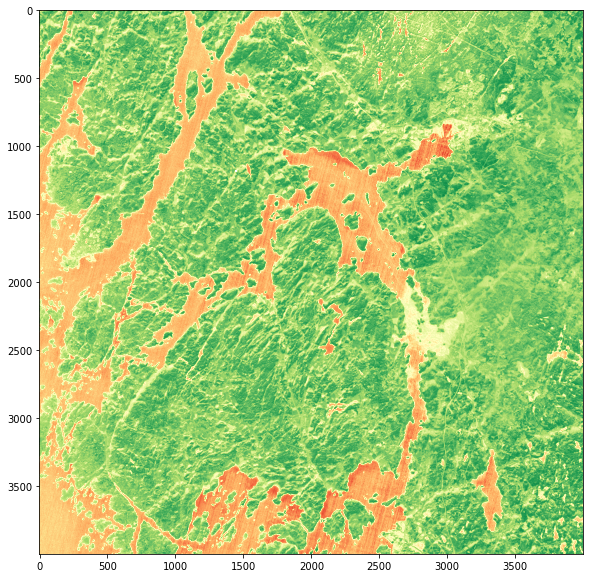

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
show(ndvi[0, 2000:6000, 4000:8000],cmap='RdYlGn', ax=ax)
plt.show()


# Example using GeoJSON



In [5]:
# Willl need geopandas
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 6.3 MB 15.8 MB/s 
     |████████████████████████████████| 16.7 MB 27.6 MB/s 


## Case study: Catalina Mountains

We can use the tool [geoson.io](https://geojson.io/#map=11/32.3843/-110.7968), to generate GeoJSON files for any desired study area. Here a Polygon is shown as the  area of study. 

We then saved the GeoJSON as `map.geoson` and uploaded to a Github.com repository, from where we will read the online geojson file. 

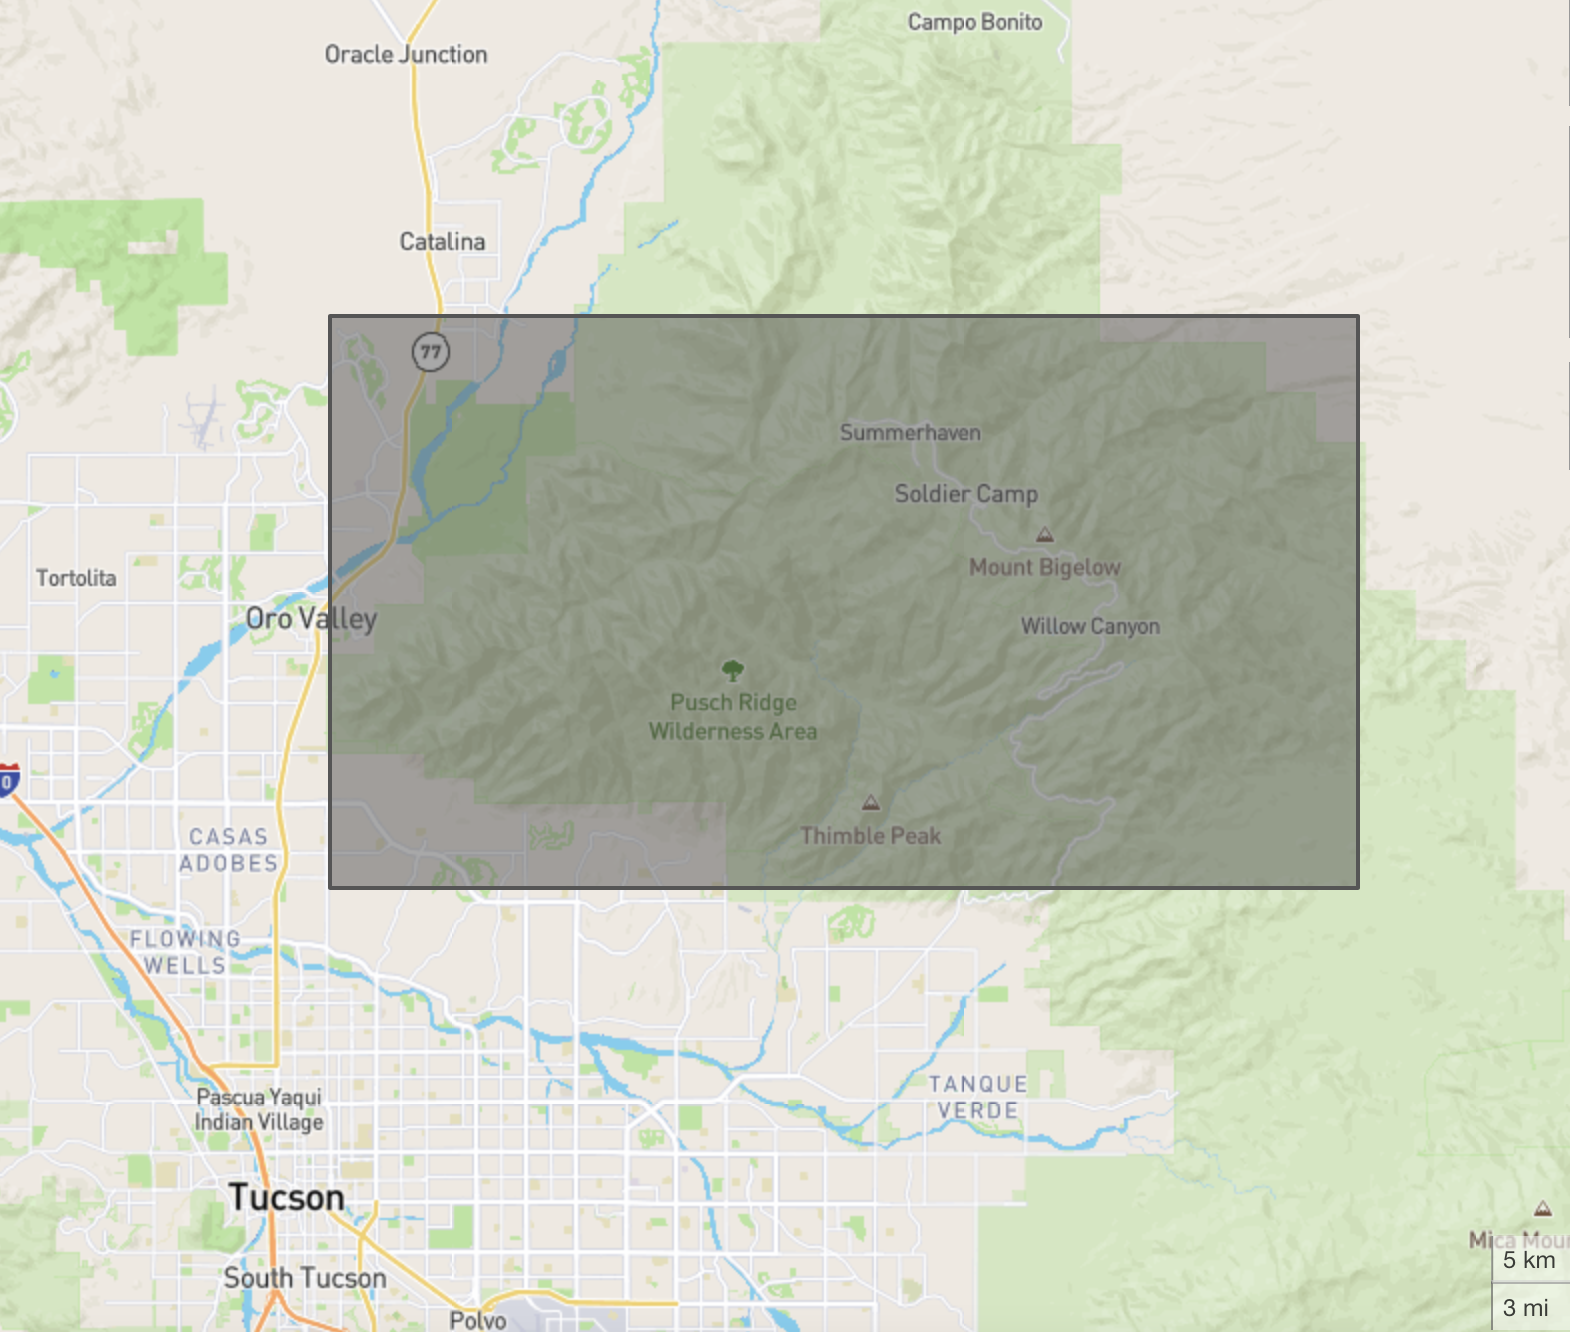

In [10]:
import geopandas as gpd

gdf = gpd.read_file('https://raw.githubusercontent.com/clizarraga-UAD7/Datasets/main/map.geoson')
bounds = gdf.bounds
print(bounds['minx'])
boundary = bounds.values.tolist()
print(boundary[0])


0   -110.959854
Name: minx, dtype: float64
[-110.95985412597656, 32.312670050625805, -110.60691833496094, 32.47848770270873]


In [11]:
search = Search(bbox=boundary[0], url='https://earth-search.aws.element84.com/v0')
print('bbox search: %s items' % search.found())


bbox search: 4266 items


In [34]:
search = Search(bbox=boundary[0], datetime='2020-05-01/2020-07-30', 
                     query={'eo:cloud_cover': {'lt': 5}}, 
                url='https://earth-search.aws.element84.com/v0')
print('bbox search: %s items' % search.found())


bbox search: 148 items


In [36]:
items = search.items()
print('%s items' % len(items))
print('%s collections' % len(items._collections))
print(items._collections)


148 items
3 collections
[sentinel-s2-l1c, sentinel-s2-l2a-cogs, sentinel-s2-l2a]


In [37]:
search = Search(bbox=boundary[0], datetime='2020-05-01/2020-07-30', collections=['sentinel-s2-l2a-cogs'], url='https://earth-search.aws.element84.com/v0')
print('bbox search: %s items' % search.found())


bbox search: 72 items


In [38]:
items = search.items() 
print(items.summary(['date', 'id', 'eo:cloud_cover'])) 


Items (72):
date                      id                        eo:cloud_cover            
2020-07-28                S2A_12SVA_20200728_0_L2A  1.67                      
2020-07-28                S2A_12SWA_20200728_0_L2A  8.4                       
2020-07-28                S2A_12SVB_20200728_0_L2A  0.99                      
2020-07-28                S2A_12SWB_20200728_0_L2A  5.84                      
2020-07-23                S2B_12SVA_20200723_0_L2A  96.94                     
2020-07-23                S2B_12SWA_20200723_0_L2A  95.66                     
2020-07-23                S2B_12SVB_20200723_0_L2A  87.66                     
2020-07-23                S2B_12SWB_20200723_0_L2A  100                       
2020-07-18                S2A_12SVA_20200718_0_L2A  33.51                     
2020-07-18                S2A_12SWA_20200718_0_L2A  53.41                     
2020-07-18                S2A_12SVB_20200718_0_L2A  6.33                      
2020-07-18                S2A_12SWB_2020

In [39]:
print(type(items[71]))
print(items[71])


<class 'satstac.item.Item'>
S2B_12SWB_20200504_0_L2A


In [40]:
print(items[71].assets)

{'overview': {'proj:shape': [343, 343], 'proj:transform': [320, 0, 499980, 0, -320, 3700020, 0, 0, 1], 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WB/2020/5/S2B_12SWB_20200504_0_L2A/L2A_PVI.tif', 'title': 'True color image', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}, 'thumbnail': {'href': 'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/12/S/WB/2020/5/4/0/preview.jpg', 'title': 'Thumbnail', 'type': 'image/png'}, 'metadata': {'href': 'https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/12/S/WB/2020/5/4/0/metadata.xml', 'title': 'Original XML metadata', 'type': 'application/xml'}, 'B11': {'proj:shape': [5490, 5490], 'proj:transform': [20, 0, 499980, 0, -20, 3700020, 0, 0, 1], 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WB/2020/5/S2B_12SWB_20200504_0_L2A/B11.tif', 'title': 'Band 11 (swir16)', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}, 'B01': {'proj:shape'

In [41]:
print(items[71].asset('red'))
print(items[71].asset('nir'))


{'proj:shape': [10980, 10980], 'proj:transform': [10, 0, 499980, 0, -10, 3700020, 0, 0, 1], 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WB/2020/5/S2B_12SWB_20200504_0_L2A/B04.tif', 'title': 'Band 4 (red)', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}
{'proj:shape': [10980, 10980], 'proj:transform': [10, 0, 499980, 0, -10, 3700020, 0, 0, 1], 'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WB/2020/5/S2B_12SWB_20200504_0_L2A/B08.tif', 'title': 'Band 8 (nir)', 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}


In [42]:

file_urlB04 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WB/2020/5/S2B_12SWB_20200504_0_L2A/B04.tif'
file_urlB08 = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/12/S/WB/2020/5/S2B_12SWB_20200504_0_L2A/B08.tif'


In [43]:
b4 = rio.open(file_urlB04)
b8 = rio.open(file_urlB08)

red = b4.read()
nir = b8.read()
# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


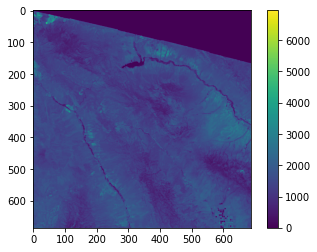

In [44]:
%matplotlib inline
import rasterio
import matplotlib.pyplot as plt
with rasterio.open(file_urlB04) as src:
   # List of overviews from biggest to smallest
   oviews = src.overviews(1)
   # Retrieve the smallest thumbnail
   oview = oviews[-1]
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
plt.imshow(thumbnail)
plt.colorbar()


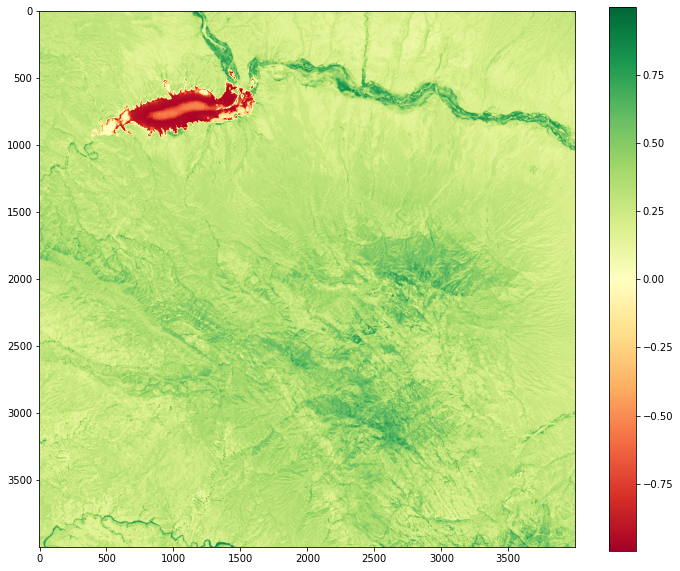

In [45]:
fig, ax = plt.subplots(figsize=(12,10))
#show(ndvi[0, 2000:6000, 4000:8000],cmap='RdYlGn', ax=ax)
plt.imshow(ndvi[0, 2000:6000, 4000:8000] ,cmap='RdYlGn')
plt.colorbar()
plt.show()
